# **Deep Q-Learning with SpaceInvaders** #
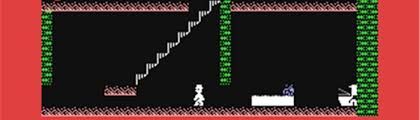



In [30]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [31]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [32]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=6)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [33]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [34]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [35]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

In [36]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions) #explore
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) #exploit
        

In [37]:
class SpaceInvadersEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('SpaceInvaders-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            , T.Resize((40,90))
            , T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)

In [38]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode score avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension = 0, size = period, step = 1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    

In [39]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

In [40]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program and Answers ##

**1. Establish a baseline performance. How well did your Deep Q-learning do on your problem?**

The RL program with SpaceInvaders-v0 provides us with a score of 148.65, which is below expectations given this baseline performance. Remove the final 100 noisy data points, and the score is 180.4. The score at the beginning of the graph is almost as high as the score at the conclusion. It demonstrates that the software does not learn how to play games to obtain a higher score. There are 6 options for each procedure, which may be due to the fact that there are a lot of actions. And resulting in the requirement for additional episodes to achieve higher learning outcomes.

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  True
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  True


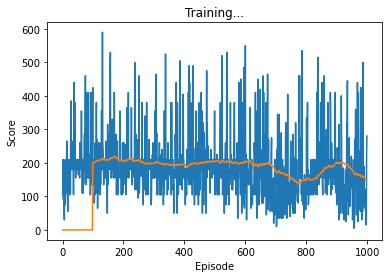

Episode 1000 
 100 episode score avg: 148.65


In [41]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**2. What are the states, the actions, and the size of the Q-table?**

State: States are different RGB image of the screen, which is an array of shape (210, 160, 3). The enviroment get each state every k frames, where k is uniformly sampled from {2,3,4}. 

Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']. There are 6 actions in this game.

The size of the Q-table: The formula: The number of states * The number of actions. Each state has different choices, the number of choices is the number of actions.

In [44]:
temp = gym.make('SpaceInvaders-v0')
print(temp.env.get_action_meanings())
print(temp.env.observation_space.shape)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


**3. What are the rewards? Why did you choose them?**

Scores from the game are the rewards. Because improving your score is the game's ultimate objective. A higher score indicates a better grasp of the rules of the game. Additionally, the results are simple to count and compare, which is advantageous for the application of the educational process.

**4. How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?**

Changes in Q occur more quickly when alpha values are close to 1. The amount that recently obtained information covers prior knowledge is determined by alpha. A factor of 0 causes the agent to learn nothing, whereas a factor of 1 causes the agent to only take into account information that has just occurred.

The score is 148.65 when the alpha is 0.001. But after 900 times, it dropped from 180.4. The score is 160.25 when the alpha is set to 0.999. It ought to demonstrate how randomly generated the gaming environment is. I increase the number of episodes to 200 to maximize the laptop's efficiency, but this causes instability in the results. Overall though, the more prior knowledge is used to improve the game score, the smaller the alpha.

The score is 137.5 when the gamma is changed to 0.1. Additionally, it is evident that the score curve with low gamma value undergoes significant alteration. Increased utilization of existing prizes can result in higher scores more quickly.

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  True
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  True


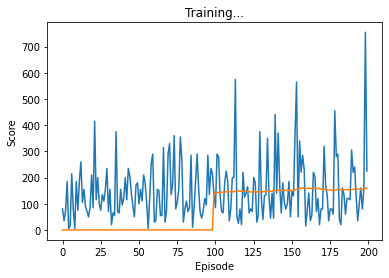

Episode 200 
 100 episode score avg: 160.25


In [45]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.999
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  True
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  True


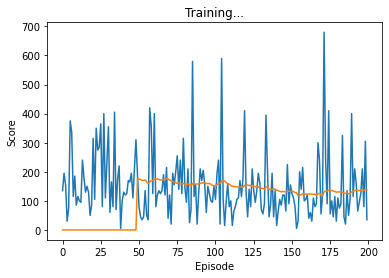

Episode 200 
 50 episode score avg: 137.5


In [46]:
batch_size = 256
gamma = 0.1
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 50)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**5. Try a policy other than e-greedy. How did it change the baseline performance?**

Setting random sampling as determine actions. 

The probability that the best behavior can be randomized decreases as the number of actions increases, according to the random sampling technique. Therefore, the random sample experiment's findings ought to be less favorable.

In reality, I discovered that the agent's gaming score is 150.2 after 200 episodes. The baseline performance will deteriorate if the e-greedy is switched to random sampling.

In [47]:
class RandomSamplingStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

In [48]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        self.current_step += 1

        action = random.randrange(self.num_actions) #explore
        return torch.tensor([action]).to(device)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  True
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  True


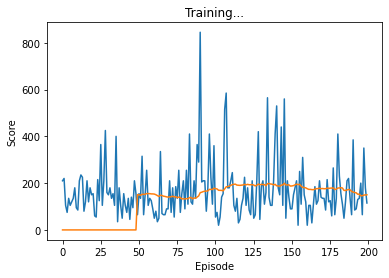

Episode 200 
 50 episode score avg: 150.2


In [49]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = RandomSamplingStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 50)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?**



I employ the epsilon greedy technique to strike a balance between growth and exploration. I establish a defined exploration rate of 1. The likelihood that an agent will explore the environment is represented by its exploration rate.

As the agent gains more knowledge from its surroundings, every time a new episode begins, e will decay at a set rate, making exploration less likely. The agent uses the surroundings "greedily" if given the chance to investigate and learn about it. We produce a random integer between 0 and 1 and use it to predict whether the agent will select exploitation or exploration at each time step. If this number is higher than epsilon, the agent will use exploitation to decide what to do next.

When the decay rate is 0.5 after the experiment, the score is 133.6. Consequently, the chance of exploration will be drastically reduced by an overly high decay rate. The agent will keep using the previously ineffective action to operate. This makes it difficult for agents to receive higher ratings.

The score is 212.0 when the initial epsilon is 0.5. As a result, a low starting epsilon will reduce the potential of exploration. As evidenced by the graph, it increases volatility. Even if it can receive a very high score, this does not help the agent's chances of doing better.

I reach the maximum number of steps each episode when the decay rate is 0.001 and the starting epsilon is 1.

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  True
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  True


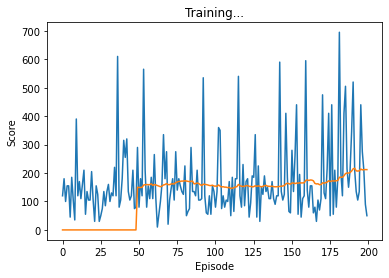

Episode 200 
 50 episode score avg: 212.0


In [50]:
batch_size = 256
gamma = 0.999
eps_start = 0.5
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 50)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  True
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  True


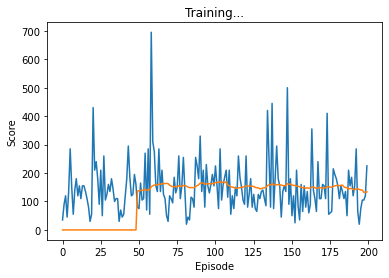

Episode 200 
 50 episode score avg: 133.6


In [51]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.5
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 50)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**7. What is the average number of steps taken per episode?**

In the loop of each episode, steps will be executed continuously until the end of the game. From the chart, the average number of steps taken per episode is 692.34.

In [52]:
def plot_steps(values, steps_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.plot(values)
    steps_avg = get_steps_average(steps_avg_period, values)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          steps_avg_period, "episode steps avg:", steps_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_steps_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        steps_avg = values.unfold(dimension = 0, size = period, step = 1) \
            .mean(dim=1).flatten(start_dim=0)
        steps_avg = torch.cat((torch.zeros(period-1), steps_avg))
        return steps_avg.numpy()
    else:
        steps_avg = torch.zeros(len(values))
        return steps_avg.numpy()
    

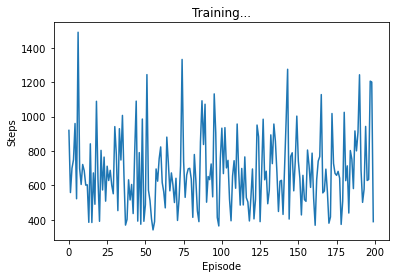

Episode 200 
 50 episode steps avg: 692.34


In [53]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
steps = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    steps.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            steps[episode] = timestep
            plot_steps(steps, 50)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**8. Does Q-learning use value-based or policy-based iteration?**

Value-based temporal difference (TD) reinforcement learning is referred to as Q learning. Even when actions are chosen based on a more exploratory or even random policy, it learns the best course of action. To determine the appropriate tactic in Q-learning, we update the Q value.

**9. Could you use SARSA for this problem?**

Yes, SARSA can deal with this issue. The method the Q value employs to choose state actions is employed before each episode. Following the action's completion, the new state should be observed and a new action should be chosen using the approach.

**10. What is meant by the expected lifetime value in the Bellman equation?**
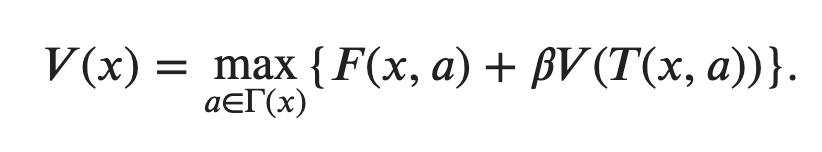

A system of functional equations describing unknown functions is known as the Bellman equation (objective functions). The functional equation approach refers to the process of using the embedding and optimization principles to create a system of functional equations. In actuality, unique solutions should be explored for certain issues.

**11. When would SARSA likely do better than Q-learning?**

As SARSA approaches convergence, possible penalties from experimental moves will be permitted. But Q-learning won't take them into account. SARSA now has a more conservative stance. While Q-learning tends to trigger the reward when exploring, SARSA will tend to avoid the risky optimal path and only learn to use it slowly if there is a high likelihood of several negative rewards nearby. Therefore, SARSA will act more strategically if there is a greater penalty for taking the next action. The likelihood of doing that action will decrease as a result of the Q-value of the current state-action pair decreasing. 

In reality, using SARSA is a preferable option if the error is expensive. And SARSA might be a preferable option if we are concerned with the benefits of the learning process.

**12. How does SARSA differ from Q-learning?**

What separates the two most significantly is how Q is updated following each operation.

Because A' is extracted from Q', SARSA strictly abides by the "epsilon-greedy" policy when using Q'. In contrast, Q-learning employs the highest Q' among all feasible actions in the following step. This gives the impression that it uses a greedy approach with =0, i.e., that there is no exploration in this section. In other words, Q-learning with Q-value update rules is not the same as SARSA.

**13. Explain the Q-learning algorithm.**

A model-free reinforcement learning algorithm called Q-learning is used to determine the worth of a given action in a given situation. The term "model-free" refers to the fact that it is not dependent on a model of the environment and that it is capable of handling stochastic transition and reward issues without the need for modifications.

Alpha for the learning rate and gamma for the discount rate are the two hyperparameters that must be specified. Gamma decides whether agents will access immediate reward or future reward, whereas alpha defines how quickly agents will adopt new Q-value.

The Q-value converges to the ideal Q-value as the loss is decreased until it is equal to zero.

The formula and pseudocode as following:

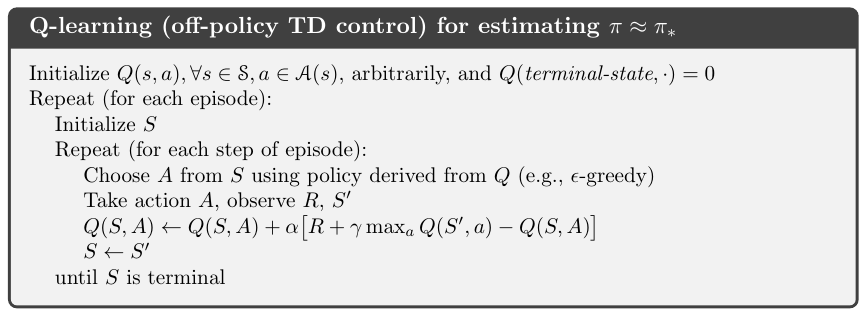

**14. Explain the SARSA algorithm.**

An algorithm for learning a Markov decision process policy is called SARSA (State action reward state action). SARSA uses the TD approach for evaluation and prediction.

A policy-based learning algorithm is one in which the SARSA agent interacts with the environment and modifies the policy in response to the actions made. The error updates and the learning rate alpha modifies the state action's Q value. The Q value is the sum of the discounted future reward from the subsequent state-activity observation and the potential reward for doing action an in state s in the next time step.

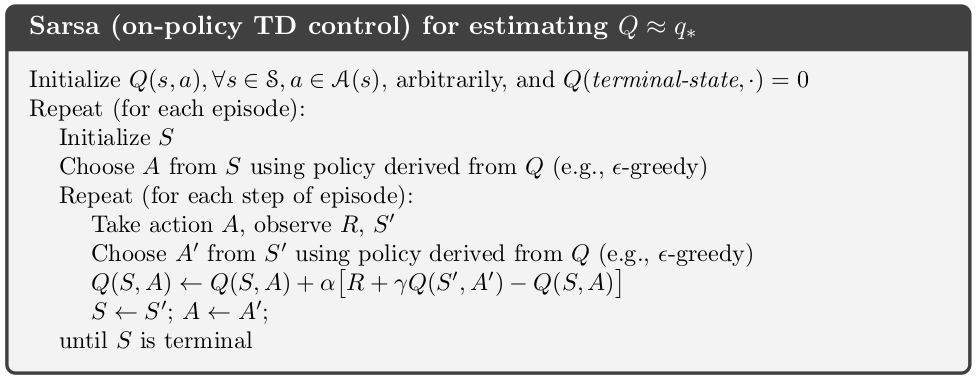

**15. Did I explain my code clearly?** <br>
I have taken references from various resources and tried to proceed in the best practice way.

#### References

https://github.com/jasonbian97/Deep-Q-Learning-Atari-Pytorch/blob/master/EnvManagers.py <br>
https://blog.paperspace.com/getting-started-with-openai-gym/ <br>
https://medium.com/analytics-vidhya/understanding-openai-baseline-source-code-and-making-it-do-self-play-part-2-9f8c4fd3e3b5


**16. Licensing.**

Copyright 2022 Divyanshu Bhardwaj

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.